# Train Based on clipping

In [1]:
import os
PROJECT = "RFCX"
EXP_NUM = "6"
EXP_TITLE = "Clipping baseline"
EXP_NAME = "exp_" + EXP_NUM + "_" + EXP_TITLE
IS_WRITRE_LOG = True
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_clip'
print('expname:' + EXP_NAME)

expname:exp_6_Clipping baseline


## Library

In [2]:
# library import
import numpy as np
import pandas as pd
# import os
import tqdm
import random
import time
import math
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import logging
import wandb
from time import sleep
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torchvision.models import resnet18, resnet34, resnet50
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torch.utils.data as torchdata
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from contextlib import contextmanager
from typing import Optional
from numpy.random import beta
from pathlib import Path
from fastprogress.fastprogress import master_bar, progress_bar
from torchviz import make_dot
from conformer import ConformerConvModule
from conformer import ConformerBlock
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

## Configuration

In [3]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# sample data
sample = torch.from_numpy(np.load(Path("../input/rfcx-species-audio-detection/train_mel_clip/0.npy")))
print(sample.shape)
# print(sample[np.newaxis, :, :].shape)

torch.Size([320, 1126])


In [5]:
class dict2(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self 

In [6]:
config = dict2({
    "fft":                2048,
    "hop":                512,
    "sr":                 48000,
    "train_clip_time":    8 * 48000,
    "mel":                320,
    "SEED":               42,
    "INPUT":              Path("../input/rfcx-species-audio-detection/train"),
    "TRAIN_AUDIO_ROOT":   Path("../input/rfcx-species-audio-detection/train_mel_clip"),
    "TEST_AUDIO_ROOT":    Path("../input/rfcx-species-audio-detection/test_mel_clip"),
    "TRAIN_TP":           Path("../input/rfcx-species-audio-detection/train_tp.csv"),
    "TRAIN_TP_MEL":       Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"),
    "SUB":                Path("../input/rfcx-species-audio-detection/sample_submission.csv"),
    "DIM":                sample.shape[0],
    "SEQ_LEN":            int(sample.shape[1] * 0.8),
    "KERNEL_SIZE":        3,
    "KERNEL_STRIDE":      1,
    "KERNEL_SIZE_SEQ":    3,
    "POOL_SIZE":          2,
    "POOL_STRIDE":        2,
    "NUM_BIRDS":          24,
    "N_FOLDS":            5,
    "BATCH_NUM":          100,
    "VALID_BATCH_NUM":    100,
    "EPOCH_NUM":          100,
    "DROPOUT":            0.35,
    "lr":                 0.001,
    "eta_min":            1e-5,
    "t_max":              10,
    "TEST_SIZE":          0.2,
    "MIXUP":              0.0,
    "MIXUP_PROB":         -1.0
})
print(config.DIM)
print(config.SEQ_LEN)

320
900


In [7]:
# seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
set_seed(config.SEED)

## Augment

In [8]:
# mixup
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    # lam = max(lam, 1 - lam)
    mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = lam * y + (1 - lam) * y[index]
    y_a, y_b = y, y[index]
    # return mixed_x, mixed_y
    return mixed_x, y_a, y_b, lam

# def mixup_criterion(y_a, y_b, lam):
#     return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Transform

In [9]:
# transforms
train_transform = transforms.Compose([
    transforms.RandomCrop((config.mel, config.SEQ_LEN)),
    # transforms.ToTensor()
])
valid_transform = transforms.Compose([
    transforms.CenterCrop((config.mel, config.SEQ_LEN)),
    # transforms.ToTensor()
])
label_transform = transforms.Compose([
    # transforms.ToTensor()
])

## Dataset

In [10]:
# Data load
df_train_tp = pd.read_csv(config.TRAIN_TP_MEL)

# add column
for col in range(24):
    df_train_tp[col] = 0

# one-hot encoding
for index, row in df_train_tp.iterrows():
    specId = row["species_id"]
    for col in range(24):
        if int(specId) == col:
            df_train_tp.iloc[index, df_train_tp.columns.get_loc(col)] = 1

# grouping
# df_train_tp = df_train_tp.groupby("recording_id", as_index=False).max()

# check
print(len(df_train_tp))
display(df_train_tp[df_train_tp["recording_id"] == "77299bde7"].head())


1216


,id,species_id,recording_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
584,584,8,77299bde7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
585,585,21,77299bde7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# load data
ids = []
specIds = []
record_ids = []
labels = []
for index, row in df_train_tp.iterrows():
    ids.append(row.values[0])
    specIds.append(row.values[1])
    record_ids.append(row.values[2])
    labels.append(row.values[3:27])

labels = np.array(labels).astype(float)

print(ids[584])
print(specIds[584])
print(record_ids[584])
print(labels[584])
print(labels[584].shape)

584
8
77299bde7
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(24,)


In [12]:
class RainforestDatasets(torch.utils.data.Dataset):
    def __init__(self, _transform, train = True):
        self.transform = _transform
        self.train = train

        # data load
        self.labelset = labels
        self.dataset = []
        for rid in ids:
            # read npy
            melspec = np.load(os.path.join(config.TRAIN_AUDIO_ROOT, str(rid) + ".npy"))
            # melspec = torch.from_numpy(melspec)
            # melspec = melspec.unsqueeze(0) # add channel for first convolution
            # melspec = melspec[np.newaxis, :, :] # add channel for first convolution
            self.dataset.append(melspec)

        self.dataset = np.array(self.dataset).astype(float)
        self.datanum = len(self.dataset)
        

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        # get data
        out_label = self.labelset[idx]
        out_data = self.dataset[idx]

        # to tensor
        out_label = torch.from_numpy(out_label).float()
        out_data = torch.from_numpy(out_data).float()
        
        # transform label
        out_data = self.transform(out_data)
        out_label = label_transform(out_label)


        out_data = out_data.transpose(0, 1)
        out_data = out_data.unsqueeze(0) # add channel for first convolution
        # print(type(out_data))
        # print(type(np.array(out_label)))
        # print(out_data.shape)

        return out_data, out_label

## Check Data

(320, 900)
(320, 1126)


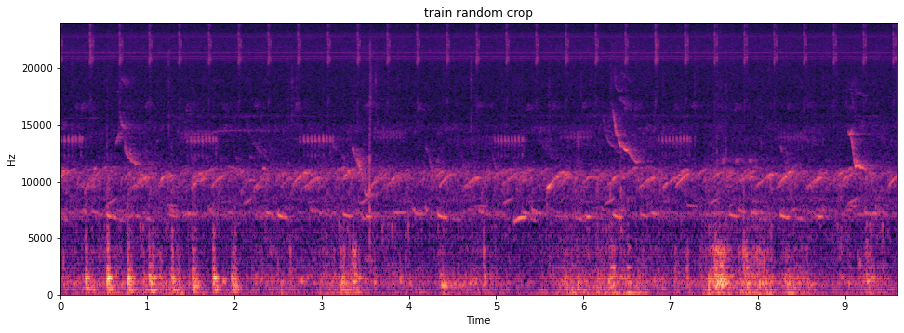

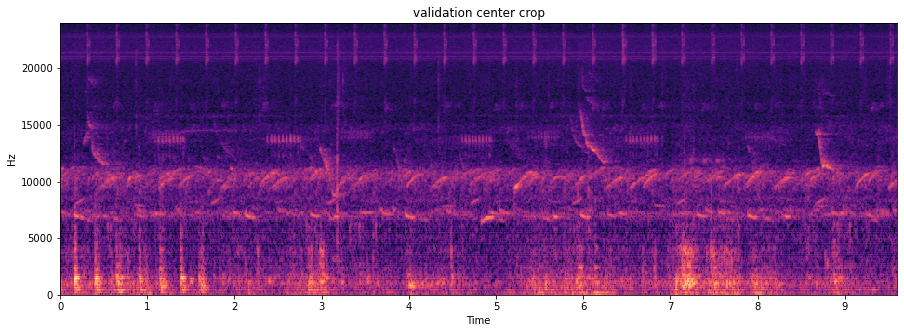

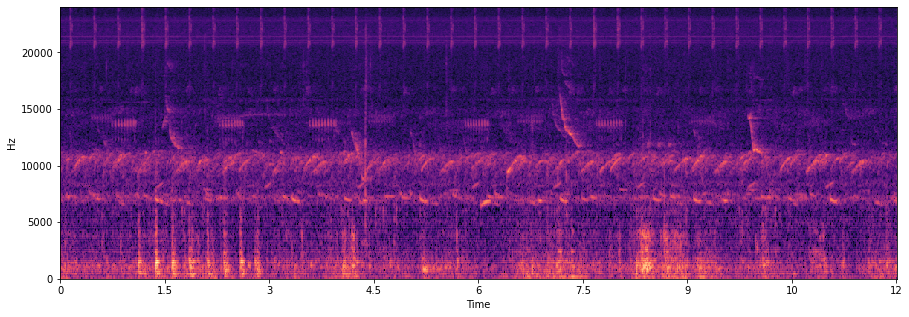

In [13]:
# ds train
import librosa.display
ds = RainforestDatasets(train_transform)
loader = DataLoader(ds)

# check aug
for x, y in loader:
    a = 1

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title='train random crop')
img = librosa.display.specshow(
    x.numpy()[0][0].T, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)


ds = RainforestDatasets(valid_transform)
loader = DataLoader(ds)

# check aug
for x, y in loader:
    a = 1

fig, ax = plt.subplots(figsize=(15, 5))
ax.set(title='validation center crop')
img = librosa.display.specshow(
    x.numpy()[0][0].T, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)

# ax.set(title=f'Mel-frequency spectrogram of {row["recording_id"]}')
# fig.colorbar(img, ax=ax, format="%+2.f dB")
print(x.numpy()[0][0].T.shape)

melspec = np.load(os.path.join(config.TRAIN_AUDIO_ROOT, str(1215) + ".npy"))
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(
    melspec, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
print(melspec.shape)

## Modeling

In [14]:
# Conformer
# https://arxiv.org/abs/2005.08100
class RainforestTransformer(nn.Module):
    def __init__(self):
        super(RainforestTransformer, self).__init__()         

        self.conv = nn.Conv2d(1, 1, (config.KERNEL_SIZE_SEQ, config.KERNEL_SIZE), stride=config.KERNEL_STRIDE)
        self.linear = nn.Linear(int((((((config.DIM - config.KERNEL_SIZE) / config.KERNEL_STRIDE) + 1) - config.POOL_SIZE) / config.POOL_STRIDE) + 1), config.DIM)
        self.dropout = nn.Dropout(config.DROPOUT)
        
        self.conformerblock = ConformerBlock(
            dim = config.DIM,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = config.DROPOUT,
            ff_dropout = config.DROPOUT,
            conv_dropout = config.DROPOUT
        )
        self.conformerblock2 = ConformerBlock(
            dim = config.DIM,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = config.DROPOUT,
            ff_dropout = config.DROPOUT,
            conv_dropout = config.DROPOUT
        )
        self.conformerblock3 = ConformerBlock(
            dim = config.DIM,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = config.DROPOUT,
            ff_dropout = config.DROPOUT,
            conv_dropout = config.DROPOUT
        )
        self.decoder = nn.Linear(1 * int((((((config.SEQ_LEN - config.KERNEL_SIZE_SEQ) / config.KERNEL_STRIDE) + 1) -  config.POOL_SIZE) / config.POOL_STRIDE) + 1) * config.DIM, config.NUM_BIRDS)

        # devided by stride
        
    def forward(self, x):
        h = F.relu(self.conv(x))
        h = F.max_pool2d(h, config.POOL_SIZE, stride=config.POOL_STRIDE)
        h = self.linear(h)
        h = h.transpose(0, 1)[0] # transpose batch and channel to delet channel dimension
        h = self.conformerblock(h)
        h = self.conformerblock2(h)
        h = self.conformerblock3(h)
        h = h.view(-1, 1 * int((((((config.SEQ_LEN - config.KERNEL_SIZE_SEQ) / config.KERNEL_STRIDE) + 1) -  config.POOL_SIZE) / config.POOL_STRIDE) + 1) * config.DIM)
        out = self.decoder(h)
        return out
RainforestTransformer()

RainforestTransformer(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=159, out_features=320, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (conformerblock): ConformerBlock(
    (ff1): Scale(
      (fn): PreNorm(
        (fn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=320, out_features=1280, bias=True)
            (1): Swish()
            (2): Dropout(p=0.35, inplace=False)
            (3): Linear(in_features=1280, out_features=320, bias=True)
            (4): Dropout(p=0.35, inplace=False)
          )
        )
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
    )
    (attn): PreNorm(
      (fn): Attention(
        (to_q): Linear(in_features=320, out_features=512, bias=False)
        (to_kv): Linear(in_features=320, out_features=1024, bias=False)
        (to_out): Linear(in_features=512, out_features=320, bias=True)
        (rel_pos_emb): Embedding(1025, 64)
        (d

## Metric

In [15]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

## Train

In [16]:
def train():

    # Stratified k-fold
    # skf = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
    msss = MultilabelStratifiedShuffleSplit(n_splits=config.N_FOLDS, test_size=config.TEST_SIZE, random_state=config.SEED)

    # Read dataset
    train_datasets = RainforestDatasets(_transform=train_transform)
    valid_datasets = RainforestDatasets(_transform=valid_transform)

    best_epochs = []
    best_lwlraps = []

    # tensorboard
    # if IS_WRITRE_LOG:
    #     writer = SummaryWriter(log_dir="./logs/" + EXP_NAME)

    # k-fold
    for kfoldidx, (train_index, valid_index) in enumerate(msss.split(labels, labels)):

        # model 
        model = RainforestTransformer()
        model.to(device)

        # init
        best_lwlrap = 0.
        best_epoch = 0

        if IS_WRITRE_LOG:
            wandb.init(config=config, project=PROJECT, group=EXP_NAME)
            # wandb.init(project=PROJECT, group=EXP_NAME)
            # config = wandb.config
            wandb.run.name = EXP_NAME + '-fold-' + str(kfoldidx)
            wandb.run.save()
            wandb.watch(model)

        # criterion
        criterion = nn.BCEWithLogitsLoss().cuda()

        # optimizer
        optimizer = Adam(params=model.parameters(), lr=config.lr, amsgrad=False)
        # print(optimizer)

        # train
        train_subset = Subset(train_datasets, train_index)
        train_loader = DataLoader(train_subset, batch_size=config.BATCH_NUM, shuffle=True)

        # validation
        valid_subset = Subset(valid_datasets, valid_index)
        valid_loader = DataLoader(valid_subset, batch_size=config.VALID_BATCH_NUM, shuffle=False)

        # scheduler
        # scheduler = CosineAnnealingLR(optimizer, T_max=config.t_max, eta_min=config.eta_min)
        num_train_steps = int(len(train_loader) * config.EPOCH_NUM)
        num_warmup_steps = int(0.1 * config.EPOCH_NUM * len(train_loader))
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

        # epoch
        mb = master_bar(range(config.EPOCH_NUM))
        mb.names = ['avg_loss', 'avg_val_loss', 'lwlrap']

        # Epoch
        for epoch in mb:

            # start time
            start_time = time.time()

            # train mode
            model.train()

            # init loss
            avg_loss = 0.

            # batch training
            train_batch_preds = []
            train_batch_labels = []
            for x_batch, y_batch in progress_bar(train_loader, parent=mb):

                # dice
                dice = np.random.rand(1)
                if dice < config.MIXUP_PROB:
                    # mixup
                    x_batch, y_batch, y_batch_b, lam = mixup_data(x_batch, y_batch, alpha=config.MIXUP, use_cuda=True)

                # forward
                preds = model(x_batch.to(device))

                if dice < config.MIXUP_PROB:
                    loss = mixup_criterion(criterion, preds, y_batch.to(device), y_batch_b.to(device), lam)
                else:
                    loss = criterion(preds, y_batch.to(device)) # It dosen't need Sigmoid, because BCE includes sigmoid function.

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss.item() / len(train_loader)

                del loss

                # add preds
                train_batch_preds.extend(torch.sigmoid(preds).detach().cpu().numpy().tolist())
                train_batch_labels.extend(y_batch.detach().cpu().numpy().tolist())

            # calc score
            score, weight = calculate_per_class_lwlrap(np.array(train_batch_labels), np.array(train_batch_preds))
            train_lwlrap = (score * weight).sum()

            # last_preds =  np.array(train_batch_preds)
            # last_labels = np.array(train_batch_labels)

            # validation mode
            model.eval()
            valid_batch_preds = []
            valid_batch_labels = []
            # valid_preds = np.zeros((len(valid_index), config.NUM_BIRDS))
            avg_val_loss = 0.

            # validation
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                preds = model(x_batch.to(device)).detach()
                loss = criterion(preds, y_batch.to(device))

                preds = torch.sigmoid(preds)
                # valid_preds[i * config.VALID_BATCH_NUM: (i+1) * config.VALID_BATCH_NUM] = preds.cpu().numpy()
                avg_val_loss += loss.item() / len(valid_loader)

                valid_batch_preds.extend(preds.detach().cpu().numpy().tolist())
                valid_batch_labels.extend(y_batch.detach().cpu().tolist())

            # calc score
            # score, weight = calculate_per_class_lwlrap(labels[valid_index], valid_preds)
            score, weight = calculate_per_class_lwlrap(np.array(valid_batch_labels), np.array(valid_batch_preds))
            lwlrap = (score * weight).sum()

            # update lr
            scheduler.step()

            # tensorboard
            if IS_WRITRE_LOG:
                # tensorboard
                # writer.add_scalar("train_loss/fold-" + str(kfoldidx), avg_loss, epoch)
                # writer.add_scalar("valid_loss/fold-" + str(kfoldidx), avg_val_loss, epoch)
                # writer.add_scalar("train_lwlrap/fold-" + str(kfoldidx), train_lwlrap, epoch)
                # writer.add_scalar("valid_lwlrap/fold-" + str(kfoldidx), lwlrap, epoch)

                wandb.log({
                    'loss/train': avg_loss,
                    'lwlrap/train': train_lwlrap,
                    'loss/validation': avg_val_loss,
                    'lwlrap/validation': lwlrap,
                    'epoch': epoch
                })


            if (epoch + 1) % 5 == 0:
                elapsed = time.time() - start_time
                mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} train_lwlrap: {train_lwlrap:.6f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
        
            if lwlrap > best_lwlrap:
                best_epoch = epoch + 1
                best_lwlrap = lwlrap
                torch.save(model.state_dict(), 'weight_best_fold' + str(kfoldidx) +'.pt')
            
        best_epochs.append(best_epoch)
        best_lwlraps.append(best_lwlrap)

        # return last_preds, last_labels

    # if IS_WRITRE_LOG:
    #     writer.close()
    
    return {
        'best_epoch': best_epochs,
        'best_lwlrap': best_lwlraps,
    }




In [17]:
result = train()
print(result)

wandb: Currently logged in as: tatsuya-takahashi (use `wandb login --relogin` to force relogin)
